In [1]:
# Basic Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

# Machine Learning
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_percentage_error

# Deep Learning
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Time series analysis
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# For the Dataset
import yfinance as yf
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Taking the data 
print("Downloading 25 years of Gold Price Data...")
data = yf.download("GC=F", period="25y", interval="1d")
data.reset_index(inplace=True)

[*********************100%***********************]  1 of 1 completed


In [3]:
# Keep only necessary columns
df = data[['Date', 'Open', 'High', 'Low', 'Close']].copy()
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values('Date', inplace=True)
print(df.head())

Price        Date        Open        High         Low       Close
Ticker                   GC=F        GC=F        GC=F        GC=F
0      2000-11-01  263.899994  263.899994  263.899994  263.899994
1      2000-11-02  264.399994  264.399994  264.399994  264.399994
2      2000-11-03  264.600006  264.600006  264.600006  264.600006
3      2000-11-06  264.500000  264.500000  264.500000  264.500000
4      2000-11-07  264.299988  264.299988  264.299988  264.299988


In [4]:
df.tail()

Price,Date,Open,High,Low,Close
Ticker,,GC=F,GC=F,GC=F,GC=F
6268,2025-10-27,4060.000000,4078.600098,3971.300049,4001.899902
6269,2025-10-28,3929.699951,3966.199951,3923.600098,3966.199951
6270,2025-10-29,3983.699951,3983.699951,3983.699951,3983.699951
6271,2025-10-30,3960.000000,4027.199951,3913.699951,4001.300049
6272,2025-10-31,4034.500000,4034.500000,3976.600098,3982.199951


In [5]:
# Flatten multi-level columns
df.columns = [col[0] if isinstance(col, tuple) else col for col in df.columns]

In [6]:
df.head()

,Date,Open,High,Low,Close
0,2000-11-01,263.899994,263.899994,263.899994,263.899994
1,2000-11-02,264.399994,264.399994,264.399994,264.399994
2,2000-11-03,264.600006,264.600006,264.600006,264.600006
3,2000-11-06,264.500000,264.500000,264.500000,264.500000
4,2000-11-07,264.299988,264.299988,264.299988,264.299988


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6273 entries, 0 to 6272
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    6273 non-null   datetime64[ns]
 1   Open    6273 non-null   float64       
 2   High    6273 non-null   float64       
 3   Low     6273 non-null   float64       
 4   Close   6273 non-null   float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 245.2 KB


In [8]:
# Set visual style
sns.set(style="whitegrid", palette="muted", font_scale=1.2)
plt.rcParams['figure.figsize'] = (12, 6)

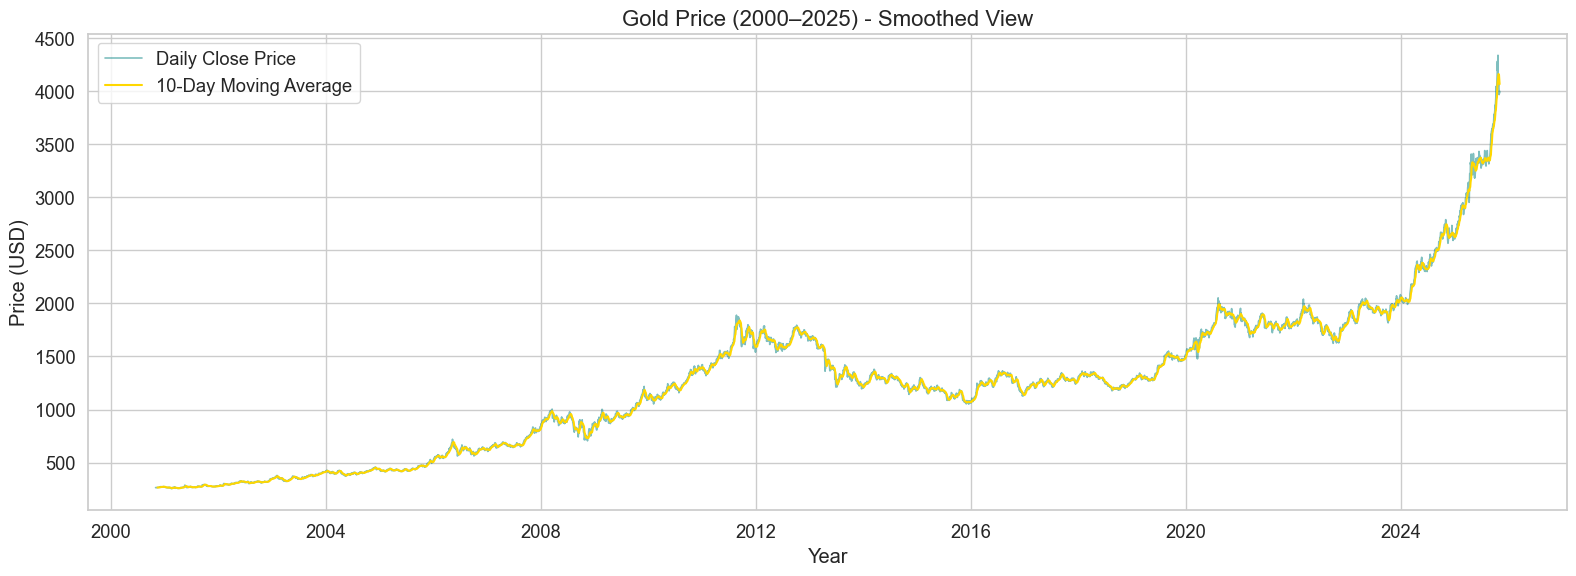

In [9]:
# 10-day moving average for smoother trend
df['MA_10'] = df['Close'].rolling(window=10).mean()

plt.figure(figsize=(16, 6))
plt.plot(df['Date'], df['Close'], color='teal', linewidth=1.2, label='Daily Close Price', alpha=0.5)
plt.plot(df['Date'], df['Close'].rolling(window=10).mean(), color='gold', linewidth=1.5, label='10-Day Moving Average') # df['MA_10'] is not working
plt.title('Gold Price (2000–2025) - Smoothed View', fontsize=16)
plt.xlabel('Year')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

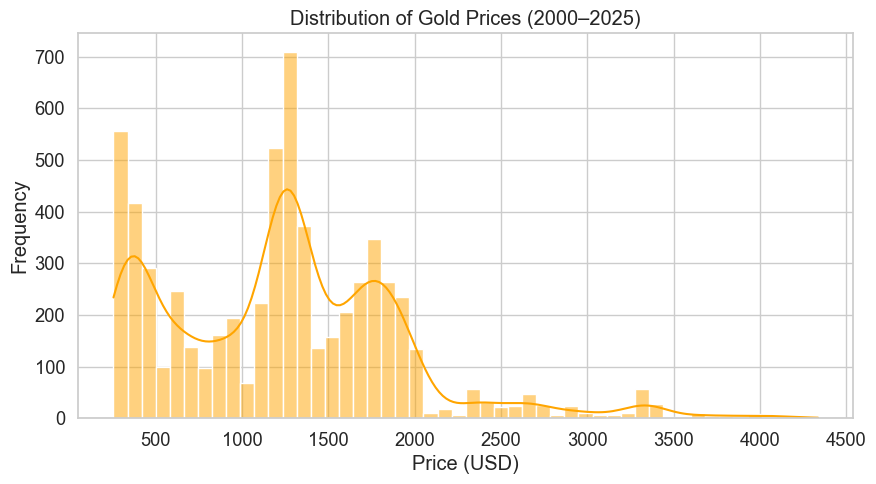

In [10]:
# What are the highest repeated values of Gold (USD)
plt.figure(figsize=(10, 5))
sns.histplot(df['Close'], bins=50, kde=True, color='orange')
plt.title('Distribution of Gold Prices (2000–2025)')
plt.xlabel('Price (USD)')
plt.ylabel('Frequency')
plt.show()

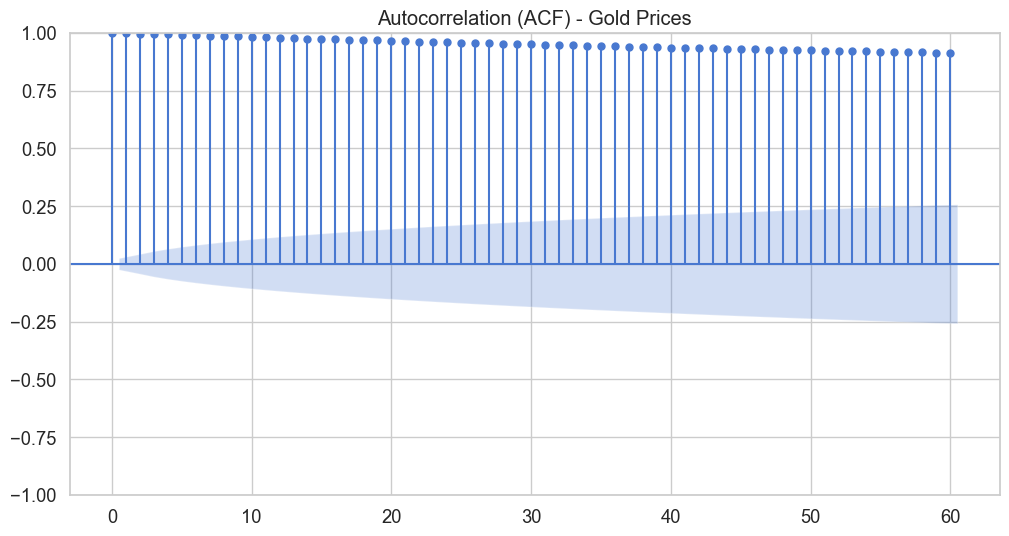

In [11]:
# Autocorrelation to check temporal dependence
plot_acf(df['Close'], lags=60)
plt.title('Autocorrelation (ACF) - Gold Prices')
plt.show()

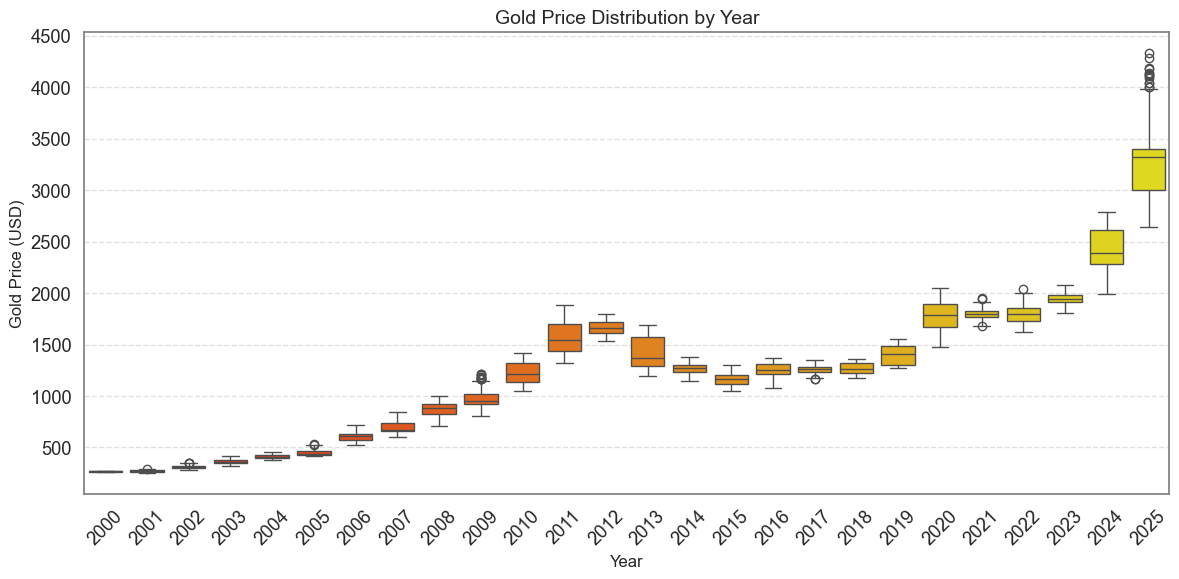

In [18]:
# Ensure Date is a datetime column (important for extracting Year)
df['Date'] = pd.to_datetime(df['Date'])
# Extract Year (if not already)
df['Year'] = df['Date'].dt.year
# Make sure 'Close' is 1D (not nested)
df['Close'] = df['Close'].astype(float)

# Boxplot by Year
plt.figure(figsize=(14, 6))
sns.boxplot(x='Year', y='Close', data=df, palette='autumn')
plt.title('Gold Price Distribution by Year', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Gold Price (USD)', fontsize=12)
plt.grid(True, axis='y', linestyle='--', alpha=0.6)
plt.xticks(rotation=45)
plt.show()

In [37]:
numeric_df = df.select_dtypes(include=['float64', 'int64'])

# Scale the data (LSTM works best with normalized input)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df[['Open', 'High', 'Low', 'Close']])

# === Create sequences for LSTM ===
def create_sequences(data, window_size=100):
    X, y = [], []
    for i in range(window_size, len(data)):
        X.append(data[i-window_size:i])   # 👈 all features now
        y.append(data[i, 3])              # 👈 predict “Close” (column index 3)
    return np.array(X), np.array(y)


window_size = 100  # use past 100 days to predict the next day
X, y = create_sequences(scaled_data, window_size)

# Split into train/test
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (4938, 100, 4)
X_test shape: (1235, 100, 4)
y_train shape: (4938,)
y_test shape: (1235,)


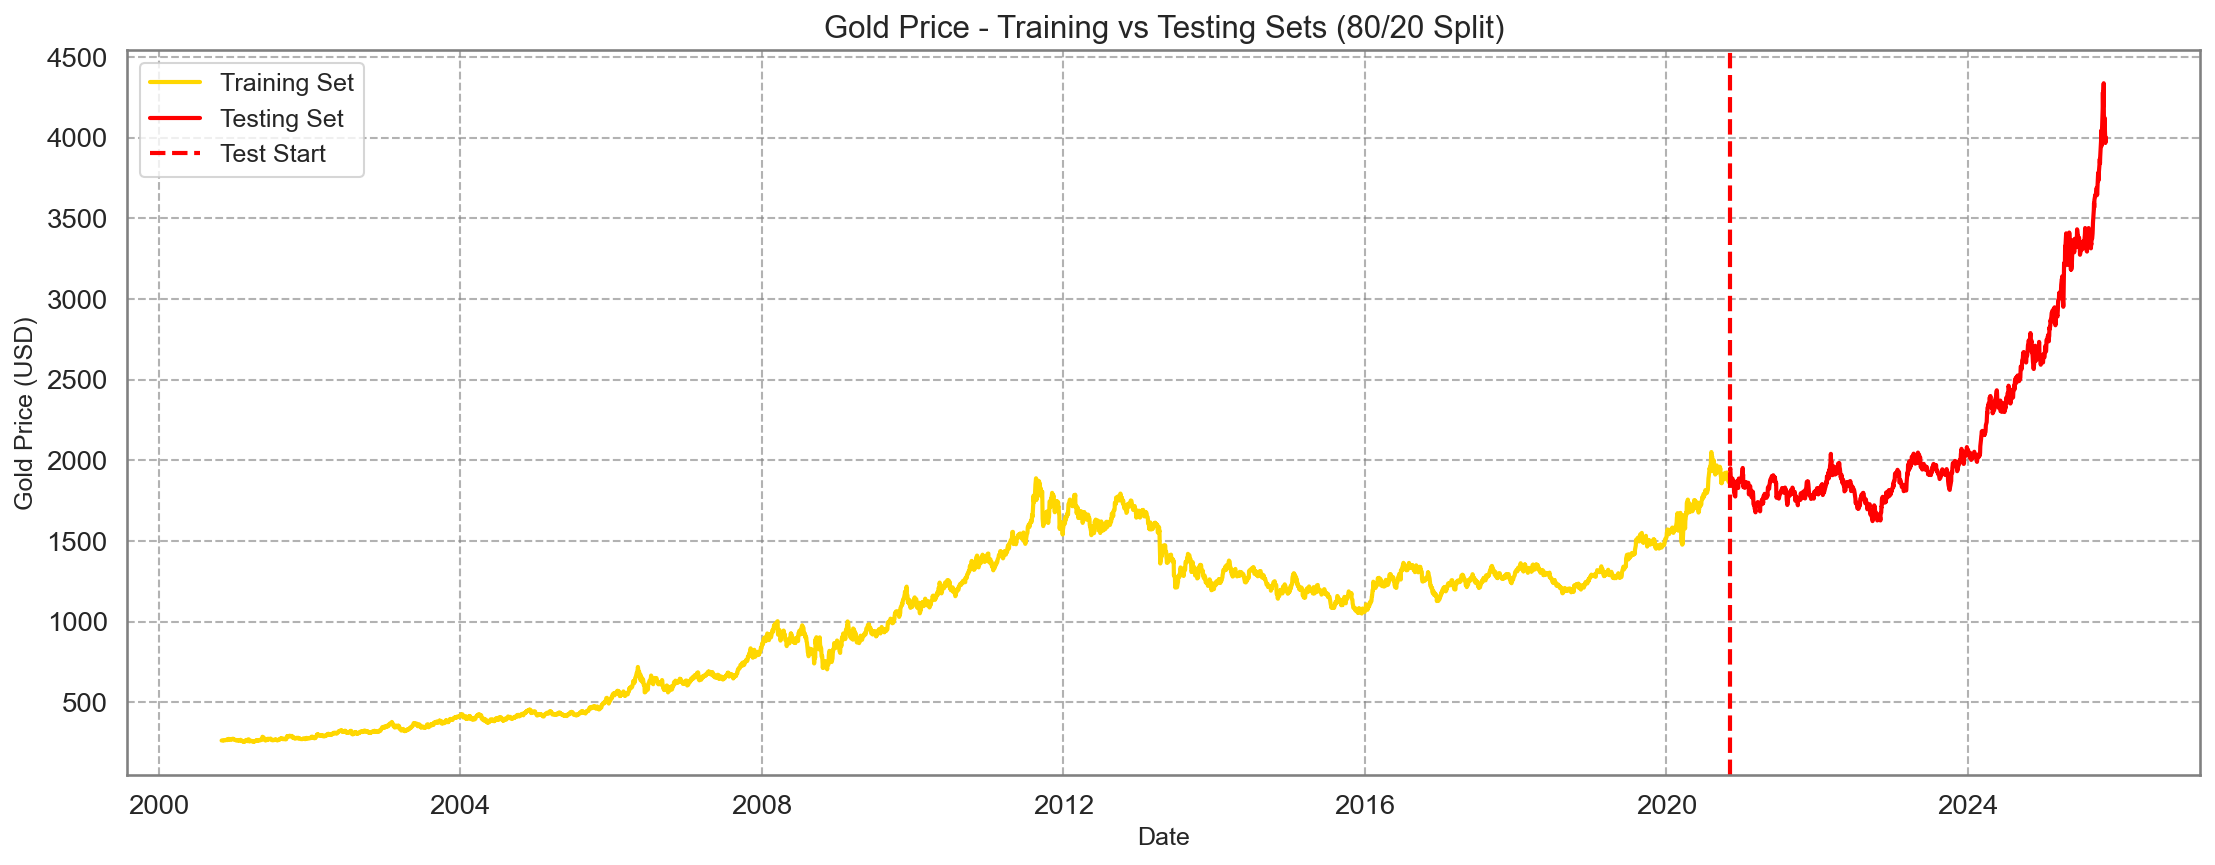

In [38]:
# ✅ Reset index to get 'Date' as a column
df_reset = df.reset_index()

# ✅ Get sizes from your split
train_size = int(len(df_reset) * 0.8)
test_size = len(df_reset) - train_size

# ✅ Plot Train vs Test Sets
plt.figure(figsize=(15, 6), dpi=150)
plt.rcParams['axes.facecolor'] = 'white'
plt.rc('axes', edgecolor='grey')

# Training Data (first 80%)
plt.plot(df_reset['Date'][:train_size], df_reset['Close'][:train_size],
         color='gold', lw=2, label='Training Set')

# Testing Data (last 20%)
plt.plot(df_reset['Date'][train_size:], df_reset['Close'][train_size:],
         color='red', lw=2, label='Testing Set')

# Add vertical line at the split point
plt.axvline(x=df_reset['Date'][train_size], color='red', linestyle='--', lw=2, label='Test Start')

plt.title('Gold Price - Training vs Testing Sets (80/20 Split)', fontsize=15)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Gold Price (USD)', fontsize=12)
plt.legend(loc='upper left', prop={'size': 12})
plt.grid(color='grey', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [40]:
# Define model
model = Sequential()
model.add(LSTM(50, return_sequences=False, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))

# Compile
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

# Train
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_test, y_test),
    verbose=1
)

Epoch 1/100
155/155 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - loss: 0.0014 - val_loss: 4.3141e-04
Epoch 2/100
155/155 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - loss: 3.5690e-05 - val_loss: 5.1047e-04
Epoch 3/100
155/155 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - loss: 3.4280e-05 - val_loss: 6.2751e-04
Epoch 4/100
155/155 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - loss: 3.3739e-05 - val_loss: 5.7491e-04
Epoch 5/100
155/155 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - loss: 3.3394e-05 - val_loss: 5.1537e-04
Epoch 6/100
155/155 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - loss: 3.2153e-05 - val_loss: 3.6702e-04
Epoch 7/100
155/155 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - loss: 3.1203e-05 - val_loss: 4.4542e-04
Epoch 8/100
155/155 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - loss: 2.9448e-05 - val_loss: 4.8573e-04
Epoch 9/100
155/155 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - loss: 2.9279e-05 - val_loss: 3.7019e-04
Epoch 10/100
155/155 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - loss: 2.8396e-05 - val_loss: 3.6997e-04
Epoch 11/100
155/155 ━━━━━━━━━━━━━━━━━━━━ 5

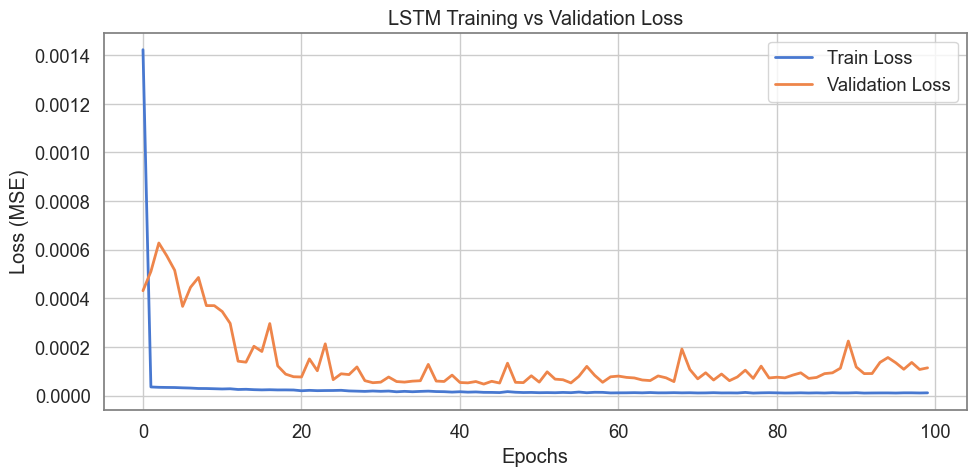

In [41]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
plt.title('LSTM Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [42]:
# Evaluate test loss (MSE)
result = model.evaluate(X_test, y_test)

39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.1433e-04


In [45]:
# Predict
y_pred = model.predict(X_test)

# Calculate MAPE and Accuracy
MAPE = mean_absolute_percentage_error(y_test, y_pred)
Accuracy = 1 - MAPE
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mse)

print("📊 Model Evaluation Metrics:")
print(f"MAE  (Mean Absolute Error): {mae:.4f}")
print(f"RMSE (Root Mean Squared Error): {rmse:.4f}")
print(f"R² Score: {r2:.4f}")
print("Test Loss:", result)
print("Test MAPE:", MAPE)
print("Test Accuracy:", Accuracy)

39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
📊 Model Evaluation Metrics:
MAE  (Mean Absolute Error): 0.0071
RMSE (Root Mean Squared Error): 0.0107
R² Score: 0.9943
Test Loss: 0.00011432511382736266
Test MAPE: 0.01310043177949761
Test Accuracy: 0.9868995682205024


In [44]:
print("\n--- SECTION 11: SAVING FINAL MODEL AND PREPROCESSOR ---")

import pickle

# --- 1️⃣ Save the trained LSTM model ---
model.save("gold_price_lstm_model.keras")
print("--- LSTM model successfully saved to 'gold_price_lstm_model.keras' ---")

# --- 2️⃣ Save the fitted MinMaxScaler ---
with open("gold_price_scaler.pkl", "wb") as f:
    pickle.dump(scaler, f)
print("--- Scaler successfully saved to 'gold_price_scaler.pkl' ---")

print("\n✅ Model and preprocessor saved successfully. Ready for future predictions!")


--- SECTION 11: SAVING FINAL MODEL AND PREPROCESSOR ---
--- LSTM model successfully saved to 'gold_price_lstm_model.keras' ---
--- Scaler successfully saved to 'gold_price_scaler.pkl' ---

✅ Model and preprocessor saved successfully. Ready for future predictions!


In [46]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import numpy as np

# --- 1) Ensure DataFrame index is datetime ---
if not np.issubdtype(df.index.dtype, np.datetime64):
    if 'Date' in df.columns:
        df['Date'] = pd.to_datetime(df['Date'])
        df.set_index('Date', inplace=True)
    else:
        raise ValueError("Index is not datetime and no 'Date' column found. Convert to datetime first.")

# --- 2) Build correct test_dates depending on how sequences were made ---
# If you created sequences with window_size, the first possible target date is at index `window_size`.
# Use the same window_size used when creating X, y.
window_size = 100  # <-- set this to the window_size you used
# `y` length equals number of dates after windowing: dates = df.index[window_size:]
dates_after_window = df.index[window_size:]

# Number of train samples used when you split X,y (not the raw df length)
n_train = len(y_train)    # y_train from your sequence split
n_test  = len(y_test)

# Now get train/test dates corresponding to sequences
train_dates = dates_after_window[:n_train]
test_dates  = dates_after_window[n_train:n_train + n_test]

# Quick sanity checks (print a few)
print("First test date:", test_dates[0])
print("Last  test date:", test_dates[-1])
print("n_test:", n_test, "len(test_dates):", len(test_dates))

# --- 3) Inverse scale y_test and y_pred using the price scaler (price_scaler) ---
# (Make sure you used a scaler fitted only on the target column)
y_test_true = price_scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
y_test_pred = price_scaler.inverse_transform(y_pred).flatten()

# --- 4) Plot ONLY the test range (use test_dates) ---
plt.figure(figsize=(12, 6), dpi=140)
plt.plot(test_dates, y_test_true, label='Actual (Test)', color='red', linewidth=1.6)
plt.plot(test_dates, y_test_pred, label='Predicted (Test)', color='dodgerblue', linestyle='--', linewidth=1.6)

# Format x-axis: yearly ticks and readable labels
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.YearLocator())      # tick every year
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xlim(test_dates[0], test_dates[-1])                # zoom to test range
plt.gcf().autofmt_xdate()

plt.title('Gold Price Prediction — Actual vs Predicted (Test Period)', fontsize=14, fontweight='bold')
plt.xlabel('Year')
plt.ylabel('Gold Price (USD)')
plt.legend()
plt.grid(alpha=0.4, linestyle='--')
plt.tight_layout()
plt.show()


First test date: 2020-12-04 00:00:00
Last  test date: 2025-10-31 00:00:00
n_test: 1235 len(test_dates): 1235


NameError: name 'price_scaler' is not defined